In [1]:
import pandas as pd
from IPython.core.display import display, HTML
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_colwidth', -1)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('fake_or_real_news.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [4]:
df.head()

Unnamed: 0  \
0  8476         
1  10294        
2  3608         
3  10142        
4  875          

                                                                                   title  \
0  You Can Smell Hillary’s Fear                                                            
1  Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)   
2  Kerry to go to Paris in gesture of sympathy                                             
3  Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!'    
4  The Battle of New York: Why This Primary Matters                                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

# TFID Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer( max_features=200000,
#                                    min_df = 0.1,
                                 stop_words='english',
                                 use_idf=True, ngram_range=(1,3))


In [6]:
%time tfidf_title_matrix = tfidf_vectorizer.fit_transform(df['title'])
%time tfidf_text_matrix = tfidf_vectorizer.fit_transform(df['text'])

Wall time: 380 ms
Wall time: 29.9 s


In [7]:
%time fakeNews_detector = MultinomialNB().fit(tfidf_text_matrix, df['label'])

Wall time: 52 ms


In [8]:

print('predicted: {}'.format(fakeNews_detector.predict(tfidf_text_matrix)[4]))
print('expected:', df.label[4])

predicted: REAL
expected: REAL


In [9]:

all_predictions = fakeNews_detector.predict(tfidf_text_matrix)
print(all_predictions)

['FAKE' 'FAKE' 'REAL' ..., 'FAKE' 'REAL' 'REAL']


In [10]:
print('accuracy {}'.format(accuracy_score(df['label'], all_predictions)))
print('confusion matrix\n {}'.format(confusion_matrix(df['label'], all_predictions)))
print('(row=expected, col=predicted)')

accuracy 0.9307024467245462
confusion matrix
 [[2741  423]
 [  16 3155]]
(row=expected, col=predicted)


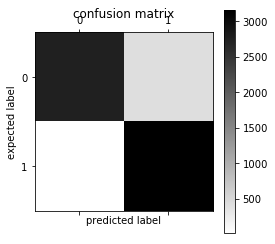

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matshow(confusion_matrix(df['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [12]:
print(classification_report(df['label'], all_predictions))

             precision    recall  f1-score   support

       FAKE       0.99      0.87      0.93      3164
       REAL       0.88      0.99      0.93      3171

avg / total       0.94      0.93      0.93      6335



# Now the real testing begins

In [13]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from textblob import TextBlob
msk = np.random.rand(len(df)) < 0.8
train = df['text'][msk]
test = df['text'][~msk]
train_label = df['label'][msk]
test_label = df['label'][~msk]


def split_into_lemmas(message):
    message = str(message).lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [ ]:
import nltk
nltk.download()

In [ ]:
!rm nltk_data-gh-pages
!unzip -o /data/gh-pages.zip -d /data


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         train,  # training data
                         train_label,  # training labels
                         cv=8,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)